#Sentiment Analysis EDA

In this notebook, we perform sentiment analysis on the Yankees subreddit, and see if and how we can correlate sentiment to <br>
real performance. We find some modest but measurable correlation in sentiment and result (win/loss). It may be interesting <br>
in future work to see how accurate of a classifier we can make to predict result from sentiment, and other metadata related <br>
to the Reddit submissions/comments.

###Import Libraries and Helper Functions

In [0]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

def BOLD(string):
    return '\033[1m' + string + '\033[0m'

###Load Joined Yankees and Reddit Data

In [0]:
mlb_df = spark.read.parquet("/FileStore/yankees_with_external/yankees_with_external.parquet").cache()

###View Data

In [0]:
mlb_df.limit(5).toPandas()

,Gm#,Date,Unnamed: 2,Tm,Unnamed: 4,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,cLI,Streak,Orig. Scheduled,New_Date,adserver_click_url,adserver_imp_pixel,archived,author,author_cakeday,author_flair_css_class,author_flair_text,author_id,brand_safe,contest_mode,created_utc,crosspost_parent,crosspost_parent_list,disable_comments,distinguished,domain,domain_override,edited,embed_type,embed_url,gilded,hidden,hide_score,href_url,id,imp_pixel,is_crosspostable,is_reddit_media_domain,is_self,is_video,link_flair_css_class,link_flair_text,locked,media,media_embed,mobile_ad_url,num_comments,num_crossposts,original_link,over_18,parent_whitelist_status,permalink,pinned,post_hint,preview,promoted,promoted_by,promoted_display_name,promoted_url,retrieved_on,score,secure_media,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,suggested_sort,third_party_trackers,third_party_tracking,third_party_tracking_2,thumbnail,thumbnail_height,thumbnail_width,title,url,whitelist_status,date_val,link_id,author_cm,author_cakeday_cm,author_flair_css_class_cn,author_flair_text_cm,body,can_gild,controversiality,created_utc_cm,distinguished_cm,edited_cm,gilded_cm,id_cm,is_submitter,link_id_cm,parent_id,permalink_cm,retrieved_on_cm,score_cm,stickied_cm,subreddit_cm,subreddit_id_cm
0,11,Tuesday Apr 13,boxscore,NYY,@,TOR,L,3,7,NaN,5-6,2,2.5,Ryu,Taillon,None,3:04,N,1550.0,1.04,-,NaN,2021-04-13,None,None,False,Yankeebot,None,,:Sterling: Spent my stimulus check on tequila,None,None,False,2021-04-13 21:06:52,None,None,None,None,self.NYYankees,None,1.618376377E9,None,None,0,False,False,None,mqbljh,None,True,False,True,False,None,None,False,None,"(None, None, None, None)",None,3598,0,None,False,all_ads,/r/NYYankees/comments/mqbljh/game_thread_yanke...,False,self,"(False, [(vEsHtx5tSfaczrzVY-xq-LsW8G0YKBrc83nP...",None,None,None,None,NaN,50,None,"(None, None, None, None, None)",#[Yankees](/r/NYYankees) [@](http://mlb.mlb.co...,False,False,NYYankees,t5_2rp0g,new,None,None,None,self,NaN,NaN,Game Thread: Yankees (5-5) @ Blue Jays (4-6) -...,https://www.reddit.com/r/NYYankees/comments/mq...,all_ads,2021-04-13,t3_mqbljh,Dagonus,None,Yankees2,:Yankees2:,Legit.,True,0,1618393091,None,false,0,gugxje7,False,t3_mqbljh,t1_gug0eoo,/r/NYYankees/comments/mqbljh/game_thread_yanke...,NaN,1,False,NYYankees,t5_2rp0g
1,11,Tuesday Apr 13,boxscore,NYY,@,TOR,L,3,7,NaN,5-6,2,2.5,Ryu,Taillon,None,3:04,N,1550.0,1.04,-,NaN,2021-04-13,None,None,False,Yankeebot,None,,:Sterling: Spent my stimulus check on tequila,None,None,False,2021-04-13 21:06:52,None,None,None,None,self.NYYankees,None,1.618376377E9,None,None,0,False,False,None,mqbljh,None,True,False,True,False,None,None,False,None,"(None, None, None, None)",None,3598,0,None,False,all_ads,/r/NYYankees/comments/mqbljh/game_thread_yanke...,False,self,"(False, [(vEsHtx5tSfaczrzVY-xq-LsW8G0YKBrc83nP...",None,None,None,None,NaN,50,None,"(None, None, None, None, None)",#[Yankees](/r/NYYankees) [@](http://mlb.mlb.co...,False,False,NYYankees,t5_2rp0g,new,None,None,None,self,NaN,NaN,Game Thread: Yankees (5-5) @ Blue Jays (4-6) -...,https://www.reddit.com/r/NYYankees/comments/mq...,all_ads,2021-04-13,t3_mqbljh,viper1856,None,Gardner,:Gardner:,especially bc hes 31 and we have him till 39 o...,True,0,1618348927,None,false,0,guf0gaj,False,t3_mqbljh,t1_guezzx9,/r/NYYankees/comments/mqbljh/game_thread_yanke...,NaN,8,False,NYYankees,t5_2rp0g
2,11,Tuesday Apr 13,boxscore,NYY,@,TOR,L,3,7,NaN,5-6,2,2.5,Ryu,Taillon,None,3:04,N,1550.0,1.04,-,NaN,2021-04-13,None,None,False,Yankeebot,None,,:Sterling: Spent my stimulus check on tequila,None,None,False,2021-04-13 21:06:52,None,None,None,None,self.NYYankees,None,1.618376377E9,None,None,0,False,False,None,mqbljh,None,True,False,True,False,None,None,False,None,"(None, None, None, None)",None,3598,0,None,False,all_ads,/r/NYYankees/comments/mqbljh/game_thread_yanke...,False,self,"(False, [(vEsHtx5tSfaczrzVY-xq-LsW8G0YKBrc83nP...",None,None,None,None,NaN,50,None,"(None, None, None, None, None)"

####Analyze Yankees Subreddit

In [0]:
print(f'Number of posts/comments in yankees subreddit within time period:    {mlb_df.count()}')

Number of posts/comments in yankees subreddit within time period:    619333


## Sentiment Analysis Pipeline

#### Define Pipeline

In [0]:
@udf
def get_sentiment_data(row):
    return row[0]['metadata']

@udf
def get_pos_prob(row):
    return row['positive']

@udf
def get_neg_prob(row):
    return row['negative']


def get_sentiment(df, text_col='body', merge_results=False):
    '''
    Use pretrained twitter sentiment model to return probability that post/comment is positive/negative.
    '''
    nlp_pipeline = PretrainedPipeline('analyze_sentimentdl_use_twitter', lang='en')

    result = nlp_pipeline.transform(df.select(F.col(text_col).alias('text')))
    result = result.withColumn('extracted_sentiment', get_sentiment_data(result.sentiment))
    result = result.withColumn('negative_prob', get_neg_prob(result.extracted_sentiment).cast('float'))
    result = result.withColumn('positive_prob', get_pos_prob(result.extracted_sentiment).cast('float'))
    
    
    result = result.select(['negative_prob', 'positive_prob'])

    if merge_results:
        df = df.withColumn("join_id", F.monotonically_increasing_id())
        result = result.withColumn("join_id", F.monotonically_increasing_id())
        result = df.join(result, 'join_id', 'inner')
        result = result.drop('join_id')
        
    return result

We use a pretrained sentiment model trained on Twitter data from John Snow Labs. This will read the <br>
body of the reddit comments/submissions and return predicted probabilites that the sentiment is <br>
negative, or positive.

####Perform Sentiment Analysis

In [0]:
sentiment = get_sentiment(mlb_df, merge_results=True)

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]


###View Positive/Negative Sentiment By Result
Let's group the submissions/comments by result (win/loss) and look at the average sentiment.

In [0]:
keep_cols = ['Gm#', 'W/L', 'positive_prob', 'negative_prob']

sub_mlb = sentiment.select(keep_cols)

avg_sentiment_by_result = sub_mlb.groupBy('W/L').avg('positive_prob', 'negative_prob').toPandas().set_index('W/L')
avg_sentiment_by_result.columns = ['positive_sentiment_probability_avg', 'negative_sentiment_probability_avg']
avg_sentiment_by_result

,positive_sentiment_probability_avg,negative_sentiment_probability_avg
W/L,,
W-wo,0.383037,0.616963
L,0.343897,0.656103
W,0.411667,0.588333
L-wo,0.366013,0.633987


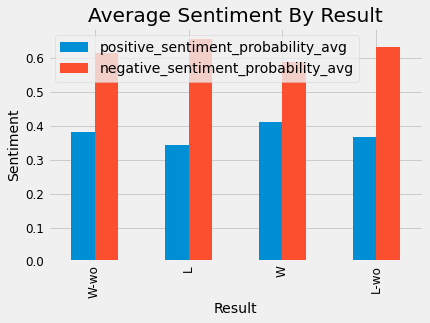

In [0]:
plt.style.use('fivethirtyeight')
avg_sentiment_by_result.plot.bar(title='Average Sentiment By Result', fontsize=12)
plt.xlabel('Result', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.show()

Let's filter down to get only wins and losses to get a better view. <br>

In [0]:
## Filter out non wins / losses
_sub_mlb = sub_mlb.filter(F.col('W/L').isin(['W', 'L']))

_avg_sentiment_by_result = _sub_mlb.groupBy('W/L').avg('positive_prob', 'negative_prob').toPandas().set_index('W/L')

_avg_sentiment_by_result.columns = ['positive_sentiment_probability_avg', 'negative_sentiment_probability_avg']

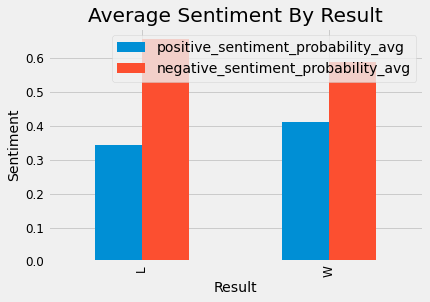

In [0]:
_avg_sentiment_by_result.plot.bar(title='Average Sentiment By Result', fontsize=12)
plt.style.use('fivethirtyeight')
plt.xlabel('Result', fontsize=14)
plt.ylabel('Sentiment', fontsize=14)
plt.show()

plt.savefig('sentiment_analysis_fig_1a.png')

Sentiment of all posts seems to be generally negative, however it does also seem that sentiment is more positive when the Yankees won. <br>
Let's see if the Pearson correlation supports this hypothesis.

In [0]:
@udf
def cast_to_int(val):
    return int(val == 'W')

_sub_mlb = _sub_mlb.withColumn('W/L', cast_to_int(_sub_mlb['W/L']).cast('int'))

corr = _sub_mlb.corr('positive_prob', 'W/L', method='pearson')

print(BOLD(f'Pearson correlation between Yankees W/L and sentiment in subreddit:   {corr}'))

Pearson correlation between Yankees W/L and sentiment in subreddit:   0.07572652645082517


Interesting. It seems that the result (win/loss) is weakly correlated to the sentiment of the post. <br>
In the future, we may attempt to create a classifier which takes in as input, the sentiment of all of the tweets related to a game and <br>
some non-information leaking metadata and tries to predict the result of the game.

###Player Sentiment
Let's now switch things up and look at the sentiment towards different players. Specifically `Aaron Judge` and `Gary Sanchez`. <br>

First use regex to create dummy variables `has_aaron_judge` and `has_gary_sanchez`.

In [0]:
## Start with the sentiment dataframe from before, which has
## all original data and sentiment cols.
from pyspark.sql.functions import *

player_sentiment = sentiment.withColumn(
    'has_aaron_judge',
    F.col('body').rlike('(?i)Aaron Judge|(?i)Judge|(?i)All Rise')
)

player_sentiment = player_sentiment.withColumn(
    'has_gary_sanchez',
    F.col('body').rlike('(?i)Gary Sanchez|(?i)Sanchez|(?i)Kraken')
)

In [0]:
keep_cols = ['Gm#', 'W/L', 'positive_prob', 'negative_prob', 'has_aaron_judge', 'has_gary_sanchez']

player_sentiment = player_sentiment.select(keep_cols)

player_sentiment.show(10)

+---+---+-------------+-------------+---------------+----------------+
|Gm#|W/L|positive_prob|negative_prob|has_aaron_judge|has_gary_sanchez|
+---+---+-------------+-------------+---------------+----------------+
| 11|  L|  6.395675E-7|    0.9999994|          false|           false|
| 11|  L|3.4278339E-10|          1.0|          false|           false|
| 11|  L|3.2413628E-32|          1.0|          false|           false|
| 11|  L|5.1653046E-11|          1.0|          false|           false|
| 11|  L|4.4360637E-18|          1.0|          false|           false|
| 11|  L|    0.5835985|    0.4164015|          false|           false|
| 11|  L| 5.202236E-10|          1.0|          false|           false|
| 11|  L|   2.83369E-5|    0.9999716|          false|           false|
| 11|  L|   0.22684097|    0.7731591|          false|            true|
| 11|  L|  2.017077E-6|     0.999998|          false|           false|
+---+---+-------------+-------------+---------------+----------------+
only s

Let's plot the sentiment of comments towards these players and measure the correlations.

In [0]:
avg_sentiment_by_judge = player_sentiment.groupBy('has_aaron_judge').avg('positive_prob', 'negative_prob').toPandas()
avg_sentiment_by_judge = avg_sentiment_by_judge.set_index('has_aaron_judge')
avg_sentiment_by_judge.columns = ['judge_positive_sentiment_probability_avg', 'judge_negative_sentiment_probability_avg']

avg_sentiment_by_sanchez = player_sentiment.groupBy('has_gary_sanchez').avg('positive_prob', 'negative_prob').toPandas()
avg_sentiment_by_sanchez = avg_sentiment_by_sanchez.set_index('has_gary_sanchez')
avg_sentiment_by_sanchez.columns = ['sanchez_positive_sentiment_probability_avg', 'sanchez_negative_sentiment_probability_avg']

avg_sentiment_by_player = pd.concat([avg_sentiment_by_sanchez, avg_sentiment_by_judge], axis=1)
avg_sentiment_by_player

,sanchez_positive_sentiment_probability_avg,sanchez_negative_sentiment_probability_avg,judge_positive_sentiment_probability_avg,judge_negative_sentiment_probability_avg
True,0.330711,0.669289,0.501658,0.498342
False,0.382735,0.617265,0.379531,0.620469


In [0]:
_player_sentiment = player_sentiment.withColumn('has_aaron_judge', F.col('has_aaron_judge').cast('int'))
_player_sentiment = _player_sentiment.withColumn('has_gary_sanchez', F.col('has_gary_sanchez').cast('int'))

corr_judge   = _player_sentiment.corr('positive_prob', 'has_aaron_judge', method='pearson')
corr_sanchez = _player_sentiment.corr('positive_prob', 'has_gary_sanchez', method='pearson')

print(BOLD(f'Pearson correlation between mention of Aaron Judge and sentiment in subreddit:   {corr_judge}'))
print(BOLD(f'Pearson correlation between mention of Gary Sanchez and sentiment in subreddit:   {corr_sanchez}'))

Pearson correlation between mention of Aaron Judge and sentiment in subreddit:   0.04195399894117602
Pearson correlation between mention of Gary Sanchez and sentiment in subreddit:   -0.009508225127328407


Interesting, it looks like posts with Gary Sanchez are on average more negative and posts with Aaron Judge <br>
are more positive (as compared to the average post (no mention of them)). It seems Aaron Sanchez is not very <br>
well liked in the Yankees subreddit. <br>

It should be noted however that these correlations are fairly weak. Not definitive.